## Load Data

In [1]:
# datadir='/Users/josesho/Google Drive/Data+Scripts/Python/data/MB312B'
datadir='/Users/josesho/Google Drive/Data+Scripts/Python/data/24-Hrs-starved-choice'

In [5]:
variables_check=input("Is this correct? ")
if variables_check=='Y':
    print("Then you can continue running the cells below.")
else:
    print("Please check your variables above.")

Is this correct? Nope
please check variables above.


## Load Libraries

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tk # ticker locating and formatting. 
import matplotlib.patches as mpatches # for custom legends.
import matplotlib.lines as mlines # for custom legends.
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Use the line of code below to see what fonts matplotlib sees on your system.
# sorted([f.name for f in mpl.font_manager.fontManager.ttflist])
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = 'Source Sans Pro'
plt.rcParams['mathtext.fontset']='custom'
plt.rcParams['mathtext.rm'] = 'Arial'
%matplotlib inline

import seaborn as sns

## Comment out the lines below before distributing this notebook.
# from jupyterthemes import jtplot
# jtplot.style('chesterish',context='poster',fscale=2,grid=False,ticks=True)
## Run sns.set, or jtplot.reset() to get matplotlib defaults.
# jtplot.reset()

import bootstrap_contrast as bs
import plot_helpers as pthelp # custom functions.

import sys
import os

# For annotating plots later.
from string import ascii_uppercase as alphabet
alphabet_labels=dict( zip(range(0,26), alphabet) )

/Users/josesho/anaconda3/envs/py3.6/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


## Munging Data

### Load Data and Munge

In [3]:
all_feeds=list()
all_meta=list()

# Get a list of CSVs whose filenames begin with 'FeedLog'.
files=os.listdir(datadir)
feedlogs=np.sort( [csv for csv in files if csv.endswith('.csv') and csv.startswith('FeedLog')] )

# check that each feedlog has a corresponding metadata CSV.
for feedlog in feedlogs:
    expected_metadata=feedlog.replace('FeedLog','MetaData')
    if expected_metadata not in files:
        raise NameError('A MetaData file for '+feedlog+' cannot be found.\n'+\
                        'MetaData files should start with "MetaData_" and '+\
                        'have the same datetime info as the corresponding FeedLog. Please check.')
# Prepare variables.
all_feeds_list=list()
all_flies_list=list()
non_feeding_flies=list()
fly_counter=0

for j, feedlog in enumerate(feedlogs):
    ## Read in metadata.
    metadata=feedlog.replace('FeedLog','MetaData')
    metadata_csv=pd.read_csv( os.path.join(datadir,metadata) )
    metadata_csv.ID=metadata_csv.ID+fly_counter
    metadata_csv.loc[:,'Genotype']=metadata_csv.Genotype.str.replace('W','w') # make sure the genotypes are correct!
    metadata_csv.rename(columns={'ID':'FlyID'},inplace=True)
    metadata_csv=metadata_csv.set_index('FlyID') # turn the ID column into the index.
    ## Save the munged metadata.
    all_flies_list.append(metadata_csv)

    ## Read in feedlog.
    feedlog_csv=pd.read_csv( os.path.join(datadir,feedlog) )
    ## Check that the feedlog has a nonzero number of rows.
    if len(feedlog_csv)==0:
        raise ValueError(feedlog+' has 0 rows. Please check!!!')
    ## Drop the feed events where `AviFile` is "Null". These events have a `RelativeTime-s` of -0.001.
    feedlog_csv.drop(feedlog_csv[feedlog_csv.AviFile=='Null'].index, inplace=True)
    ## You have to ADD 1 to match the feedlog FlyID with the corresponding FlyID in `metadata_csv`.
    ## Also, because we want to concatenate all feedlogs, we also add the number of flies in previous feedlogs.
    feedlog_csv.FlyID=feedlog_csv.FlyID+1
    if j>0:
        feedlog_csv.FlyID=feedlog_csv.FlyID+fly_counter
    ## Add current fly count to fly_counter.
    fly_counter+=len(metadata_csv)
    ## Define 2 padrows per fly, per food choice,
    ## that will ensure feedlogs for each FlyID fully capture the entire 6-hour duration.
    for flyid in np.sort(metadata_csv.index.unique()):
        ## Identify flies that did not have any feed events. Were these chambers empty? Or the flies dead?
        if flyid not in feedlog_csv.FlyID.unique():
            non_feeding_flies.append(flyid)
        for choice in feedlog_csv.ChoiceIdx.unique():
            padrows=pd.DataFrame( [ [np.nan,np.nan,choice,
                                    flyid,choice,'NIL',
                                    np.nan,np.nan,0,
                                    False,0.5,'PAD', # 0.5 seconds
                                    ],
                                    [np.nan,np.nan,choice,
                                    flyid,choice,'NIL',
                                    np.nan,np.nan,0,
                                    False,21891,'PAD', # 6 hrs, 5 min, 1 sec in seconds.
                                    ] ]
                                )
            padrows.columns=feedlog_csv.columns
            # Add the row to `temp`.
            feedlog_csv=feedlog_csv.append(padrows,ignore_index=True) # there is no `inplace` argument for append.
    ## Assign feed choice to feedlog_csv
    choice1=metadata_csv['Food 1'].unique()
    choice2=metadata_csv['Food 2'].unique()
    if len(choice1)>1 or len(choice2)>1:
        raise ValueError('More than one food choice detected per food column. Please check the file '+metadata)
    choice1=choice1[0]
    choice2=choice2[0]
    if len(feedlog_csv.ChoiceIdx.unique())>2:
        raise ValueError('The ChoiceIdx column in '+feedlog+\
                         str(len(feedlog_csv.ChoiceIdx.unique()))+\
                         ' food choices. There should only be exactly 2.')
    feedlog_csv['FoodChoice']=np.repeat('xx',len(feedlog_csv))
    feedlog_csv.loc[np.where(feedlog_csv.ChoiceIdx==0)[0],'FoodChoice']=choice1
    feedlog_csv.loc[np.where(feedlog_csv.ChoiceIdx==1)[0],'FoodChoice']=choice2
    ## Add column to identify which FeedLog file the feed data came from.
    feedlog_csv['FeedLog_rawfile']=np.repeat(feedlog, len(feedlog_csv))
    ## Turn the 'Valid' column into integers.
    ## 1 -- True; 0 -- False
    feedlog_csv['Valid']=feedlog_csv.Valid.astype('int')
    ## Save the munged feedlog.
    all_feeds_list.append(feedlog_csv)

# Join all processed feedlogs and metadata into respective DataFrames.
all_feeds=pd.concat(all_feeds_list)
all_flies=pd.concat(all_flies_list)

# Munge `all_flies`.
## Compute column in `all_flies` for total feed counts per fly.
feed_counts_per_fly=all_feeds.dropna().groupby('FlyID').count().AviFile
for fly in non_feeding_flies:
    feed_counts_per_fly.loc[fly]=0
feed_counts_per_fly.index.name='FlyID'

all_flies['FeedCount']=feed_counts_per_fly
## Create column for experimental status.
all_flies['Expt_Group']='xx'
all_flies.loc[np.where(all_flies.Genotype.str.startswith('w1118'))[0]+1,
                 'Expt_Group']='Sibling Control'
all_flies.loc[np.where(all_flies.Genotype.str.contains('>'))[0]+1,
                 'Expt_Group']='Offspring'
if 'xx' in all_flies.Expt_Group.unique():
    raise ValueError('There are unrecognized genotypes in ',all_flies.Genotype.unique(),\
                     '.\nPlease check all genotypes adhere to Drosophila nomenclature')
all_flies['Plot_group']=all_flies['Expt_Group'].str.cat(all_flies.Temperature.astype('str'),sep=' ')

# Munge `all_feeds`.
## Change name columns.
all_feeds.columns=['StartTime','StartFrame','FeedTubeIdx','FlyID',
                      'ChoiceIdx','AviFile','FeedVol_µl','FeedDuration_ms',
                      'Evap_mm3/s','Valid','RelativeTime_s','ExperimentState',
                      'FoodChoice','FeedLog_rawfile']
## Compute feed volume in nanoliters for convenience.
all_feeds['FeedVol_nl']=all_feeds['FeedVol_µl']*1000
## Compute feeding speed.
all_feeds['FeedSpeed_nl/s']=all_feeds['FeedVol_nl']/(all_feeds['FeedDuration_ms']/1000)
## Convert `RelativeTime_s` to DateTime object.
all_feeds['RelativeTime_s']=pd.to_datetime(all_feeds['RelativeTime_s'],unit='s')
all_feeds['feed_duration_s']=all_feeds.FeedDuration_ms/1000      

## Sort by FlyID, then by RelativeTime
all_feeds.sort_values(['FlyID','RelativeTime_s'],inplace=True)
## Clean up and reset the index.
all_feeds.reset_index(inplace=True)
all_feeds.drop(['index','StartTime','FeedTubeIdx','ExperimentState','StartFrame'],
                  axis=1,inplace=True)

## Merge all_feeds and all_flies
all_feeds=pd.merge(all_feeds,all_flies.reset_index(),
                   left_on='FlyID',right_on='FlyID')
## Drop extraneous columns from all_feeds.
all_feeds.drop(['Minimum Age','Maximum Age','Food 1','Food 2','FeedCount'],axis=1,inplace=True)

## Change relevant columns to categorical.
for catcol in ['Genotype','Expt_Group','FoodChoice','Temperature']:
    all_feeds[catcol]=all_feeds.loc[:,catcol].astype('category',ordered=True)
## Set order of Expt_Group.
all_feeds['Expt_Group']=all_feeds.loc[:,'Expt_Group'].cat.set_categories(['Sibling Control', 'Offspring'],ordered=True)

## Create column for grouping and plotting.
all_feeds['Plot_group']=all_feeds['Expt_Group'].str.cat(all_feeds.Temperature.astype('str'),
                                                              sep=' ')
all_feeds['Plot_group_food']=all_feeds['Expt_Group'].str.cat([all_feeds.FoodChoice,
                                                                    all_feeds.Temperature.astype('str')],
                                                                   sep=' ')

# Print summary of feedlogs read in.
print('Feedlogs analyzed='+str(len(feedlogs))+'\n')
print(feedlogs)
# Print the fly count.
print('\nFly Count')
print('---------')
print( all_flies.groupby('Genotype').count().Sex )
# Print non-feeding flies.
print('\nFlies with 0 feed events: ',non_feeding_flies,'\n')

Feedlogs analyzed=2

['FeedLog_2017-08-25_10-57-52.csv' 'FeedLog_2017-08-25_11-09-26.csv']

Fly Count
---------
Genotype
w1118    60
Name: Sex, dtype: int64

Flies with 0 feed events:  [] 



In [4]:
# Groupby, sum, take feed volume, fill NaNs, convert to DataFrame, then records, then DataFrame again.
grouped_foodchoice=pd.DataFrame(
                    pd.DataFrame(all_feeds.
                                 groupby(['FlyID','FoodChoice']). # CANNOT GROUP BY TEMPERATURE HERE.
                                 sum()[['FeedVol_nl','Valid']].
                                     fillna(0)).
                    to_records()
)

grouped_nofoodchoice=pd.DataFrame(
                    pd.DataFrame(all_feeds.
                                 groupby(['FlyID']). # CANNOT GROUP BY TEMPERATURE HERE.
                                 sum()[['FeedVol_nl','Valid']].
                                     fillna(0)).
                    to_records()
)
# add metadata.
grouped_foodchoice=pd.merge(grouped_foodchoice,all_flies.reset_index(),
                            left_on='FlyID',right_on='FlyID')
grouped_nofoodchoice=pd.merge(grouped_nofoodchoice,all_flies.reset_index(),
                              left_on='FlyID',right_on='FlyID')

for df in [grouped_foodchoice, grouped_nofoodchoice]:
    # Rename the columns used for y-values, so they are appropriately labelled in the final plots.
    df.rename(columns={"FeedVol_nl": "Total Intake (nl)", 
                       "Valid": "Feed Count"},inplace=True)
    df.drop(['FeedCount', 'Minimum Age','Maximum Age', 'Food 1', 'Food 2'],axis=1,inplace=True)

# Reset `grouped_foodchoice `Plot_group` column.
grouped_foodchoice.loc[:,'Plot_group']=grouped_foodchoice['Expt_Group'].\
                                        str.\
                                        cat([grouped_foodchoice.FoodChoice,
                                             grouped_foodchoice.Temperature.astype('str')],
                                            sep=' ')

### Define Plotting Groups

In [5]:
# Set up the two plotting indicies we will use for the rest of the plots.
# Wonder if there is a way to automate this?
groupings=[(('Sibling Control 100mM_Sucrose 22',
             'Sibling Control 100mM_Sucrose 29'),
            
            ('Offspring 100mM_Sucrose 22', 
             'Offspring 100mM_Sucrose 29'),
            
            ( 'Sibling Control 100mM_Sucrose_100mM_Arabinose 22',
             'Sibling Control 100mM_Sucrose_100mM_Arabinose 29'),
            
            ('Offspring 100mM_Sucrose_100mM_Arabinose 22',
             'Offspring 100mM_Sucrose_100mM_Arabinose 29')),
           
           (('Sibling Control 22',
             'Sibling Control 29'),
            ('Offspring 22', 
             'Offspring 29'))
          ]

### Create Palettes

In [6]:
### Palette for Genotype.
# np.sort(all_feeds.Genotype.unique()) # The sibling controls should be the last two.
genotype_palette=dict( zip( np.sort(all_flies.Genotype.unique()), 
                           ['red','royalblue','deepskyblue'] ) 
                     )
desat_list=[]
for k in genotype_palette.keys():
    desat_list.append(sns.desaturate(genotype_palette[k],0.5))
genotype_palette_desat=dict( zip( all_flies.Genotype.unique(), desat_list ) )
print(genotype_palette)
print(genotype_palette_desat)

{'w1118': 'red'}
{'w1118': (0.75, 0.25, 0.25)}


In [7]:
### Palette for Food Choice
foodchoice_palette=dict( zip( np.sort(all_feeds.FoodChoice.unique()), 
                             ['midnightblue','red'] ) 
                       )
desat_list=[]
for k in foodchoice_palette.keys():
    desat_list.append(sns.desaturate(foodchoice_palette[k],0.5))
foodchoice_palette_desat=dict( zip( all_feeds.FoodChoice.unique(), desat_list ) )

# Create custom handles for the foodchoice.
# See http://matplotlib.org/users/legend_guide.html#using-proxy-artist
raster_legend_handles=[]
timecourse_legend_handles=[]
for key in foodchoice_palette.keys():
    patch=mpatches.Patch(color=foodchoice_palette[key], label=key)
    raster_legend_handles.append(patch)
    timecourse_legend_handles.append(patch)
    
timecourse_legend_handles.append( mlines.Line2D([],[],color='k',label='Total Consumption') )

print(foodchoice_palette)
print(foodchoice_palette_desat)

{'100mM_Sucrose': 'midnightblue', '100mM_Sucrose_100mM_Arabinose': 'red'}
{'100mM_Sucrose': (0.18333333333333335, 0.18333333333333335, 0.35392156862745094), '100mM_Sucrose_100mM_Arabinose': (0.75, 0.25, 0.25)}


## Raster Plots and Timecourse

In [10]:
# munging for timecourse data.
all_feeds_withfood_timecourse=pd.DataFrame ( 
                            all_feeds.groupby(['Plot_group','FoodChoice']).\
                            resample('10min',on='RelativeTime_s').\
                            sum().to_records() )
all_feeds_withfood_timecourse_fv=all_feeds_withfood_timecourse.loc[:,['Plot_group','FoodChoice',
                                                    'RelativeTime_s','FeedVol_µl']]
all_feeds_withfood_timecourse_fv.fillna(0,inplace=True)

all_feeds_timecourse_fv=pd.DataFrame(all_feeds_withfood_timecourse_fv.\
                                     groupby(['Plot_group','RelativeTime_s']).\
                                     sum().to_records())

for df in [all_feeds_withfood_timecourse_fv,all_feeds_timecourse_fv]:
    df['feed_time_s']=df.RelativeTime_s.dt.hour*3600+\
    df.RelativeTime_s.dt.minute*60+\
    df.RelativeTime_s.dt.second

plotting Sibling Control 29 rasters
plotting Sibling Control 29 100mM_Sucrose timecourse
plotting Sibling Control 29 100mM_Sucrose_100mM_Arabinose timecourse


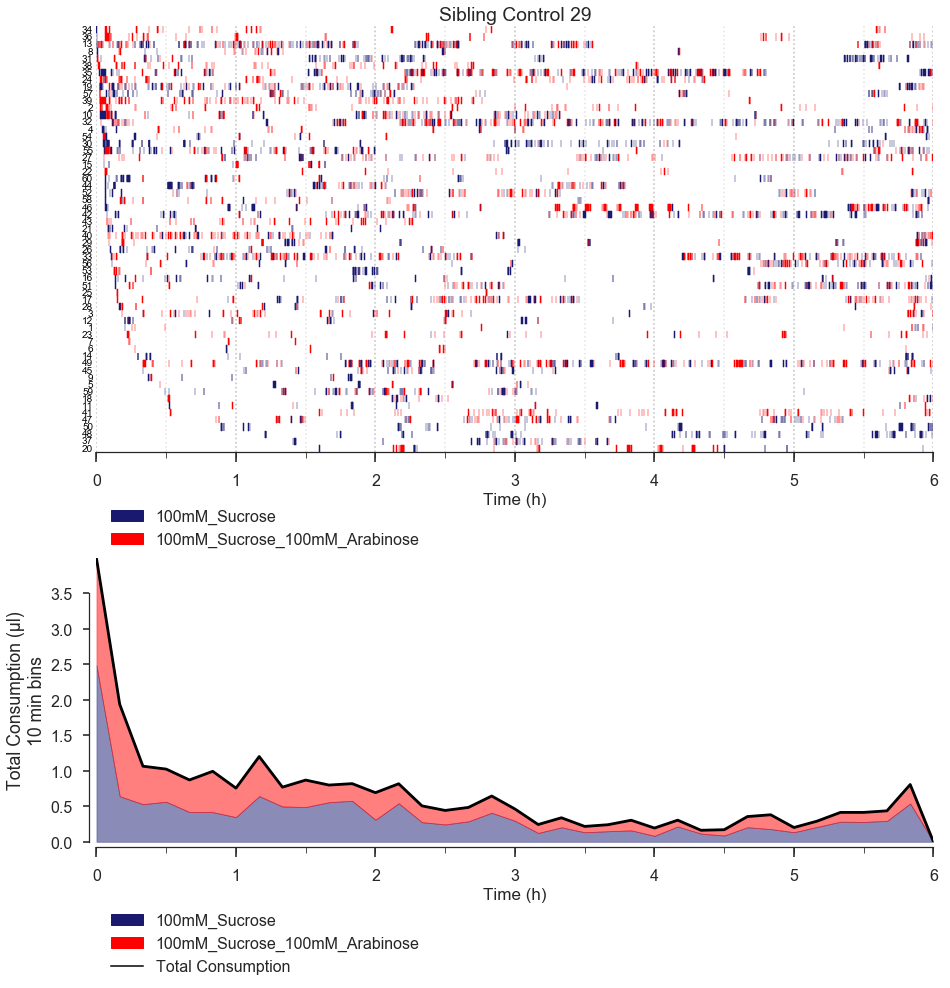

In [17]:
add_flyid_labels=True # Set to False if you don't want to show the flyids on the y-axis.

maxflycount=all_flies.groupby('Plot_group').count().Sex.max()

sns.set(style='ticks',context='poster')
if add_flyid_labels:
    ws=0.3
else:
    ws=0.1
ncols=int(len(all_feeds.Plot_group.unique()))

if ncols>1:
    fsize=(32,15)
else:
    fsize=(15,15)
fig,axx=plt.subplots(nrows=2,
                     ncols=ncols,
                     figsize=fsize,
                     gridspec_kw={'wspace':ws,
                                  'hspace':0.3,
                                  'height_ratios':(3,2)} )

for c, group in enumerate(all_feeds.Plot_group.unique()):
    
    print('plotting {0} {1}'.format(group,'rasters'))
    # Plot the raster plots.
    if ncols>1:
        rasterax=axx[0,c]
    else:
        rasterax=axx[0]
    rasterax.xaxis.grid(True,linestyle='dotted',which='major',alpha=1)
    rasterax.xaxis.grid(True,linestyle='dotted',which='minor',alpha=0.5)
    
    # Grab only the feeds and flies we need.
    tempfeeds=all_feeds[all_feeds.Plot_group==group]
    temp_allflies=tempfeeds.FlyID.unique().tolist()

    # Grab only the columns we need.
    tempfeeds=tempfeeds[['FlyID','Plot_group','FoodChoice','RelativeTime_s','feed_duration_s']]#.dropna()
    # Munge the data for raster plotting.
    tempfeeds['feed_time_s']=tempfeeds.RelativeTime_s.dt.hour*3600+\
                              tempfeeds.RelativeTime_s.dt.minute*60+\
                              tempfeeds.RelativeTime_s.dt.second+\
                              tempfeeds.RelativeTime_s.dt.microsecond/1000000

    # Order the flies properly.
    ## First, drop non-valid feeds, then sort by feed time and feed duration,
    ## then pull out FlyIDs in that order.
    temp_feeding_flies=tempfeeds[~np.isnan(tempfeeds.feed_duration_s)].\
                            sort_values(['feed_time_s','feed_duration_s']).FlyID.\
                            drop_duplicates().tolist()
    ## Next, identify which flies did not feed (aka not in list above.)
    temp_non_feeding_flies=[fly for fly in temp_allflies if fly not in temp_feeding_flies]
    ## Now, join these two lists.
    flies_in_order=temp_feeding_flies+temp_non_feeding_flies
    
    for k, flyid in enumerate(flies_in_order):
        tt=tempfeeds[tempfeeds.FlyID==flyid]
        for idx in [idx for idx in tt.index if ~np.isnan(tt.loc[idx,'feed_duration_s'])]:
            rasterax.axvspan(xmin=tt.loc[idx,'feed_time_s'], 
                           xmax=tt.loc[idx,'feed_time_s']+tt.loc[idx,'feed_duration_s'],
                           ymin=(1/maxflycount)*(maxflycount-k-1),
                           ymax=(1/maxflycount)*(maxflycount-k),
                           label="_"*k + tt.loc[idx,'FoodChoice'],
                           color=foodchoice_palette[ tt.loc[idx,'FoodChoice'] ], 
                           alpha=1)
        if add_flyid_labels:
            if flyid in temp_non_feeding_flies:
                label_color='grey'
            else:
                label_color='black'
            rasterax.text(-85, (1/maxflycount)*(maxflycount-k-1) + (1/maxflycount)*.5, 
                        flyid,
                        color=label_color,
                        verticalalignment='center',
                        horizontalalignment='right',
                        fontsize=10)
    rasterax.yaxis.set_visible(False)
    rasterax.set_title(group)
    
    # Plot the time course feed volume plots.
    if ncols>1:
        timecourseax=axx[1,c]
    else:
        timecourseax=axx[1]
    temp_nofood=all_feeds_timecourse_fv[all_feeds_timecourse_fv.Plot_group==group]
    basex=np.repeat(0,len(temp_nofood))
    
    for d, food in enumerate(all_feeds.FoodChoice.unique()):
        # Plot the time course feed volume plots.
        print('plotting {0} {1} {2}'.format(group,food,'timecourse'))
        
        temp_withfood=all_feeds_withfood_timecourse_fv[
            (all_feeds_withfood_timecourse_fv.Plot_group==group) &
            (all_feeds_withfood_timecourse_fv.FoodChoice==food)]

        timecourseax.fill_between(x=temp_withfood['feed_time_s'],
                                  y1=np.add(temp_withfood['FeedVol_µl'],basex),
                                  y2=basex,
                                  color=foodchoice_palette[food],lw=0.75,alpha=0.5)
        basex=temp_withfood['FeedVol_µl']
        
    timecourseax.plot(temp_nofood['feed_time_s'],
                      temp_nofood['FeedVol_µl'],
                      'k-')
    timecourseax.set_ylim(0,all_feeds_timecourse_fv['FeedVol_µl'].max())
    if c==0:
        timecourseax.set_ylabel('Total Consumption (µl)\n10 min bins')
    
    # Format x-axis for both axes.
    for a in [rasterax, timecourseax]:
        a.set_xlim(0,21600)
        a.xaxis.set_ticks(range(0,25200,3600))
        a.xaxis.set_minor_locator( tk.MultipleLocator(base=1800) )
        a.set_xlabel('Time (h)',fontsize=17)
        newlabels=[str(int(t/3600)) for t in a.xaxis.get_ticklocs(minor=False)]
        a.set_xticklabels(newlabels)
        a.tick_params(axis='x', which='major',length=10)
        a.tick_params(axis='x', which='minor',length=6)
        
    sns.despine(ax=rasterax,left=True,trim=True)
    sns.despine(ax=timecourseax,trim=True,offset={'left':7,'bottom':5})

if ncols>1:
    rasterlegend_ax=axx[0,0]
    timecourselegend_ax=axx[1,0]
else:
    rasterlegend_ax=axx[0]
    timecourselegend_ax=axx[1]
    
rasterlegend_ax.legend(loc='upper left',bbox_to_anchor=(0,-0.1),handles=raster_legend_handles)
timecourselegend_ax.legend(loc='upper left',bbox_to_anchor=(0,-0.2),handles=timecourse_legend_handles)

## Cumulative Metrics 

In [18]:
# Set the grouping order here.
grouping=['FlyID','FoodChoice','Genotype','Expt_Group','Temperature']

# Create the `groupby.resamp` pandas object
feeds_resamp=all_feeds.groupby(grouping)\
                         .resample('5min',on='RelativeTime_s')
# Compute the sum for each resampled window.
feeds_resamp_sum=feeds_resamp.sum()
# Drop extraneous columns.
feeds_resamp_sum.drop(['FlyID','ChoiceIdx','Evap_mm3/s'],
                     axis=1,inplace=True)
# Calculate cumulative sum.
# Note the usage of `groupby` twice, and also of `fillna` twice, to ensure proper handling of NaNs.
feeds_resamp_cumsum=feeds_resamp_sum.groupby(grouping).cumsum()\
                                    .groupby(grouping).fillna(method='pad').fillna(0)
# Re-name the columns.
feeds_resamp_cumsum.columns='Cumul'+feeds_resamp_sum.columns
# 'Unstack' the DataFrame to facilitate plotting.
# See https://stackoverflow.com/questions/22779516/unstack-multiindex-dataframe-to-flat-data-frame-in-pandas
feeds_resamp_cumsum=pd.DataFrame(feeds_resamp_cumsum.to_records())
# Rename the 'Valid' column to Feed Counts.
feeds_resamp_cumsum.rename(columns={'CumulValid':'CumulFeedCounts'},inplace=True)
# Change relevant columns to categorical.
for catcol in ['Genotype','Expt_Group','FoodChoice']:
    feeds_resamp_cumsum[catcol]=feeds_resamp_cumsum.loc[:,catcol].astype('category',ordered=True)
# Add time column (in minutes) to facilitate plotting.
feeds_resamp_cumsum['RelativeTime_min']=feeds_resamp_cumsum.RelativeTime_s.dt.hour*60 + feeds_resamp_cumsum.RelativeTime_s.dt.minute

In [19]:
fig_label_kwargs=dict(xy=(-0.3,1.01),
                      xycoords='axes fraction',
                      fontsize=20,
                      fontweight='bold',
                      clip_on=False)
genotype=[g for g in feeds_resamp_cumsum.Genotype.unique() if not g.upper().startswith('W')][0]

for v in ['CumulFeedVol_nl', 'CumulFeedCounts']:
    f, ax_arr=plt.subplots(ncols=len(feeds_resamp_cumsum.Temperature.unique()),
                           nrows=len(feeds_resamp_cumsum.FoodChoice.unique()),
                           figsize=(13,10),
                           sharex=True,sharey=True,
                           gridspec_kw=dict(wspace=0.5,hspace=0.5))

    for col, temp in enumerate(feeds_resamp_cumsum.Temperature.unique()):
        for row,foodtype in enumerate(feeds_resamp_cumsum.FoodChoice.unique()):
            temp_df=feeds_resamp_cumsum[(feeds_resamp_cumsum.FoodChoice==foodtype) & 
                                       (feeds_resamp_cumsum.Temperature==temp)]
            ax_plot=ax_arr[row,col]
            sns.tsplot(data=temp_df,ci=95,ax=ax_plot,
                       time='RelativeTime_min',unit='FlyID',
                       condition='Genotype',value=v,
                       color=['red','royalblue','deepskyblue'],
#                        color=genotype_palette, ## Not sure why this doesn't work?
            #            alpha=temp_alpha,
                       linewidth=1.5)
            ax_plot.set_title(' '.join([foodtype,str(temp),'ºC']),
                              fontsize=18)
            ax_plot.xaxis.set_major_locator( tk.MultipleLocator(base=60) )
            ax_plot.xaxis.set_minor_locator( tk.MultipleLocator(base=30) )

    for j,ax in enumerate(ax_arr[0, :]): # First row.
        ax.legend().set_visible(False)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.annotate(s=str( alphabet_labels[j*2] ),**fig_label_kwargs)
        sns.despine(ax=ax,trim=True,offset=5)

    for j,ax in enumerate(ax_arr[1, :]): # Second row.
        ax.set_ylabel('')
        ax.legend(loc='upper center',bbox_to_anchor=(-0.5,-0.3), # xycoords
                  ncol=3,fontsize=14)
        ax.set_xlabel('Time (h)',fontsize=17)
        newlabels=[str(int(int(t)/60)) for t in ax.xaxis.get_ticklocs(minor=False)]
        ax.set_xticklabels(newlabels)
        ax.annotate(s=str( alphabet_labels[(j*2)+1] ),**fig_label_kwargs )
        sns.despine(ax=ax,trim=True,offset=5,)
    
    if 'nl' in v:
        ylab='Cumulative Consumption\nper fly (nl)'
    elif 'Counts' in v:
        ylab='Cumulative Feed Count\nper fly'
    else:
        ylab='Please specify\ndependant variable!'
    for j,ax in enumerate(ax_arr[:,0]):
        ax.set_ylabel(ylab, fontsize=16)
    ax_arr[1,0].legend().set_visible(False)

    f.suptitle(genotype,fontsize=22)

IndexError: list index out of range

## Total Intake Per Fly

/Users/josesho/anaconda3/envs/py3.6/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


ValueError: low >= high

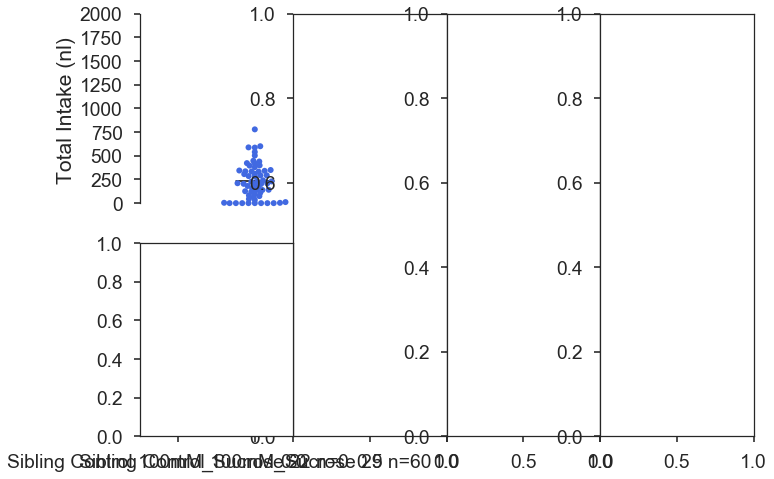

In [20]:
dfs=[]
for j,df in enumerate( [grouped_foodchoice,grouped_nofoodchoice] ):
    f,b=bs.contrastplot(data=df,x='Plot_group',y='Total Intake (nl)',
                        color_col='Genotype',
                        float_contrast=False,
                        custom_palette=['royalblue','red','deepskyblue'],
                        font_scale=1.2,
                        swarm_ylim=(-40,2000),
                        idx=groupings[j],
                       )
    # Collect the contrast.
    dfs.append(b)
# Show the contrasts.
pd.concat(dfs)

## Feed Count

In [ ]:
dfs=[]
for j,df in enumerate( [grouped_foodchoice,grouped_nofoodchoice] ):
    f,b=bs.contrastplot(data=df,x='Plot_group',y='Feed Count',
                        color_col='Genotype',
                        float_contrast=False,
                        custom_palette=['royalblue','red','deepskyblue'],
                        font_scale=1.2,
                        swarm_ylim=(-25,300),
                        idx=groupings[j],
                       )
    # Collect the contrast.
    dfs.append(b)
# Show the contrasts.
pd.concat(dfs)

## Latency to first feed

In [ ]:
# First, make sure that `all_feeds` is sorted by FlyID, then by RelativeTime_s
all_feeds.sort_values(axis=0, by=['FlyID','RelativeTime_s'],inplace=True)
# Get the indicies of invalid padrows.
padrows=all_feeds[all_feeds.Valid==0].index
# Drop these rows, then group by, and get the first feed event.
firstfeeds_foodchoice_temp=all_feeds.drop(padrows)\
                                        .groupby(['FlyID','FoodChoice','Temperature'])\
                                        .head(1)
firstfeeds=all_feeds.drop(padrows).groupby(['FlyID',]).head(1)
# Add column that converts the RelativeTime_s as minutes
for df in [firstfeeds_foodchoice_temp,firstfeeds]:
    df['Seconds_to_first_feed']=firstfeeds_foodchoice_temp.RelativeTime_s.dt.hour*3600+\
                                firstfeeds_foodchoice_temp.RelativeTime_s.dt.minute*60+\
                                firstfeeds_foodchoice_temp.RelativeTime_s.dt.second
    # Convert seconds to first feed to minutes
    df['First_feed_latency_min']=df.Seconds_to_first_feed / 60
    # Rename the latency column for nice plotting later.
    df.rename(columns={"First_feed_latency_min":"Latency to\nFirst Feed (min)"},inplace=True)
    
# Add relevant columns to the DataFrames.
firstfeeds_foodchoice_temp['Plot_Group']=firstfeeds_foodchoice_temp['Expt_Group']\
                                        .str.cat([firstfeeds_foodchoice_temp.FoodChoice,
                                                  firstfeeds_foodchoice_temp.Temperature.astype('str')],
                                                 sep=' ')
firstfeeds['Plot_Group']=firstfeeds['Expt_Group'].str.cat(firstfeeds.Temperature\
                                                          .astype('str'),
                                                          sep=' ')

In [ ]:
dfs=[]
for j,df in enumerate( [firstfeeds_foodchoice_temp,firstfeeds] ):
    f,b=bs.contrastplot(data=df,x='Plot_Group',y='Latency to\nFirst Feed (min)',
                        color_col='Genotype',
                        float_contrast=False,
                        custom_palette=['royalblue','red','deepskyblue'],
                        font_scale=1.2,
                        swarm_ylim=(-10,400),
                        idx=groupings[j],
                       )
    # Collect the contrast.
    dfs.append(b)
# Show the contrasts.
pd.concat(dfs)

## Feed Volume and Feed Speed

In [ ]:
boxplot_args=dict(hue='Genotype',
                  palette=genotype_palette,
                  showmeans=True,
                  meanline=True,
                  showfliers=False,
                  width=0.4,
                  meanprops=dict(linewidth=2,color='k',linestyle=':'),
                  medianprops=dict(linewidth=2,),
                  boxprops=dict(linewidth=0,alpha=0.65),
                  capprops=dict(linewidth=1.5),
                  whiskerprops=dict(linewidth=1.5),
                  flierprops=dict(markersize=4,markerfacecolor='grey',
                                  alpha=0.5,marker='o')
                 )

axes_divider_args=dict(position="bottom", 
                 size="100%", 
                 pad=0.75)

violinplot_args=dict(showextrema=False, showmeans=False, widths=0.3)

In [ ]:
sns.set(context='poster',style='ticks')


## List to save axes.
contrast_feed_vol_list=[]
contrast_feed_rate_list=[]

## Initialise figure.
f,ax_arr=plt.subplots(nrows=2,
                      ncols=2,
                      figsize=(13,12),
#                       sharex=True,
                      gridspec_kw=dict(wspace=0.4, # width-wise spacing.
                                       hspace=0.5) # height-wise spacing.
                     )
## Set xticks positions.
xticks=[0.1,0.82]

### Make plot.
for col,temp in enumerate(all_feeds.Temperature.unique()):
    ## Name axes for easy referencing.
    boxplot_feed_vol=ax_arr[0,col]
    boxplot_feed_rate=ax_arr[1,col]
    
    ## Boxplot Feed Volume.
    df=all_feeds[all_feeds.Temperature==temp]
    sns.boxplot(data=df,
                x='Plot_group',y='FeedVol_nl',
                ax=boxplot_feed_vol,**boxplot_args                   
               )
    boxplot_feed_vol.set_xlabel('')
    ## Contrast Plot Feed Volume
    divider=make_axes_locatable(boxplot_feed_vol)
    contrast_feed_vol=divider.append_axes(sharex=boxplot_feed_vol,**axes_divider_args)
    # Compute boostraps.
    fv_boots=bs.bootstrap(x1=df[df.Expt_Group=='Sibling Control'].FeedVol_nl.dropna(),
                          x2=df[df.Expt_Group=='Offspring'].FeedVol_nl.dropna())
    # Plot half-violin boostraps.
    v1=contrast_feed_vol.violinplot(fv_boots.stat_array, [xticks[1]], **violinplot_args)
    bs.halfviolin(v1)
    # Plot mean and ci.
    pthelp.meanci(fv_boots.summary, fv_boots.bca_ci_low, fv_boots.bca_ci_high, xticks[1], 
           ax=contrast_feed_vol, size=11, lw=1.9)
    # Format the pvalue.
    if fv_boots.pvalue_2samp_ind_ttest<1e-3:
        pval=pthelp.sci_nota(fv_boots.pvalue_2samp_ind_ttest)
    else:
        pval=np.round(fv_boots.pvalue_2samp_ind_ttest,3)
    # Annotate delta, 95CI, and p-value.
    annot_text=str( np.round(fv_boots.summary,2) )+\
    ' ['+str( np.round(fv_boots.bca_ci_low,2) )+\
    ';'+str( np.round(fv_boots.bca_ci_high,2) )+\
    ']\nP='+str( pval )
    contrast_feed_vol.annotate(annot_text, 
                               xy=(xticks[1]*0.95, fv_boots.summary),
                               fontsize=18,
                               horizontalalignment='right',
                               verticalalignment='center'
                              )
    # Only add ylabels if these are the leftmost axes.
    if col==0:
        boxplot_feed_vol.set_ylabel('Feed Volume (nl)',fontsize=18)
        contrast_feed_vol.set_ylabel('Delta\nFeed Volume (nl)',fontsize=18)
    else:
        boxplot_feed_vol.set_ylabel('')
    ## Save axes to list.
    contrast_feed_vol_list.append(contrast_feed_vol)
    
    ## Boxplot Feed Rate
    sns.boxplot(data=df,
                x='Plot_group',y='FeedSpeed_nl/s',
                ax=boxplot_feed_rate,**boxplot_args
               )
    boxplot_feed_rate.set_xlabel('')
    ## Contrast Plot Feed Rate.
    divider=make_axes_locatable(boxplot_feed_rate)
    contrast_feed_rate=divider.append_axes(sharex=boxplot_feed_rate,**axes_divider_args)
    # Compute boostraps.
    fr_boots=bs.bootstrap(x1=df[df.Expt_Group=='Sibling Control'].loc[:,'FeedSpeed_nl/s'].dropna(),
                          x2=df[df.Expt_Group=='Offspring'].loc[:,'FeedSpeed_nl/s'].dropna())
    # Plot half-violin boostraps.
    v2=contrast_feed_rate.violinplot(fr_boots.stat_array, [xticks[1]], **violinplot_args)
    bs.halfviolin(v2)
    # Plot mean and ci.
    pthelp.meanci(fr_boots.summary, fr_boots.bca_ci_low, fr_boots.bca_ci_high, xticks[1], 
           ax=contrast_feed_rate, size=11, lw=1.9)
    # Format the pvalue.
    if fr_boots.pvalue_2samp_ind_ttest<1e-3:
        pval=pthelp.sci_nota(fr_boots.pvalue_2samp_ind_ttest)
    else:
        pval=np.round(fr_boots.pvalue_2samp_ind_ttest,3)
    # Annotate delta, 95CI, and p-value.
    annot_text=str( np.round(fr_boots.summary,2) )+\
    ' ['+str( np.round(fr_boots.bca_ci_low,2) )+\
    ';'+str( np.round(fr_boots.bca_ci_high,2) )+\
    ']\nP='+str( pval )
    contrast_feed_rate.annotate(annot_text, 
                               xy=(xticks[1]*0.95, fr_boots.summary),
                               fontsize=18,
                               horizontalalignment='right',
                               verticalalignment='center'
                              )
    # Only add ylabels if these are the leftmost axes.
    if col==0:
        boxplot_feed_rate.set_ylabel('Feed Speed (nl/s)',fontsize=18)
        contrast_feed_rate.set_ylabel('Delta\nFeed Speed (nl/s)',fontsize=18)
    else:
        boxplot_feed_rate.set_ylabel('')
    # Save axes to list.
    contrast_feed_rate_list.append(contrast_feed_rate)

### Aesthetic tweaks.
## equalize ylims across each row, first for the boxplot axes.
for rownum in [0,np.shape(ax_arr)[0]-1]:
    pthelp.normalize_ylims(ax_arr[rownum, :])
## Now for the feed vol contrasts.
pthelp.normalize_ylims(contrast_feed_vol_list,include_zero=True,draw_zero_line=True)
## And now for the feed rate contrasts.
pthelp.normalize_ylims(contrast_feed_rate_list,include_zero=True,draw_zero_line=True)

for ax in ax_arr.flat:
    ax.set_xticks(xticks) # tweak the position of the xtick labels.
    sns.despine(ax=ax,trim=True,offset=5)

## Make sure xticks in contrast plots line up with the boxplot xticks.
for axes_list in [contrast_feed_vol_list,
                  contrast_feed_rate_list]:
    for ax in axes_list:
        ax.set_xticks(xticks)
        sns.despine(ax=ax,trim=True)
    
for j,ax in enumerate(ax_arr[0, :]): # First row.
    ax.legend().set_visible(False)
    ax.annotate(s=str( alphabet_labels[j*2] ),**fig_label_kwargs)

for j,ax in enumerate(ax_arr[1, :]): # Second row.
    ax.legend(loc='upper center',bbox_to_anchor=(-0.25,-1.9), # xycoords
              ncol=3,fontsize=14)
    ax.annotate(s=str( alphabet_labels[(j*2)+1] ),**fig_label_kwargs )
    
ax_arr[1,0].legend().set_visible(False)
f.suptitle(genotype,fontsize=18,y=0.94,fontweight='bold')
plt.show()